# Atividade 3 - Nathan bandeira 



## Sobre
O algoritmo é responsável pro analisar imagens de destroços e danos em infraestruturas (Prédios e casas por extensão)
os datasets são passados pelo algoritmo e então concedem um "Peso" para detecção dos datasets subsequetnes

## 1. Configuração e Carregamento do Dataset



In [ ]:
# dependências
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

dataset_path = r"E:\\skeletonkey"  
classes = sorted([d for d in os.listdir(dataset_path) 
                 if os.path.isdir(os.path.join(dataset_path, d)) and d.startswith('classe')])

print(f"Classes detectadas no dataset: {classes}")
# Verifica se existem imagens em cada classe
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Classe {cls}: {len(images)} imagens")


Classes detectadas no dataset: ['classe1', 'classe2', 'classe3']
Classe classe1: 100 imagens
Classe classe2: 100 imagens
Classe classe3: 90 imagens


## 2. Transformações de Imagem e Preparação dos Dados

Define as imagens para 128x128 para um analise mais precisa e na hora de aplicar o K-FOLDING transforma o 128x128 para 64x64 e 32x32

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),  # Converter para tons de cinza
    transforms.Resize((128, 128)),  # Maior resolução para capturar detalhes dos danos
    transforms.RandomHorizontalFlip(p=0.3),  # Data augmentation
    transforms.RandomRotation(10),  # Pequenas rotações
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


## 3. Implementação do Dataset Personalizado

 encapsula as imagens dos diretórios `classe*` e retorna tensores e rótulo

In [ ]:
class BuildingDamageDataset(Dataset):
    def __init__(self, base_dir, classes, transform=None):
        self.base_dir = base_dir
        self.classes = classes
        self.transform = transform
        self.images, self.labels = [], []
        
        for idx, cls in enumerate(classes):
            folder = os.path.join(base_dir, cls)
            # Filtra imagens
            image_files = [f for f in os.listdir(folder) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            for img_name in image_files:
                img_path = os.path.join(folder, img_name)
                self.images.append(img_path)
                self.labels.append(idx)
        
        print(f"Total de imagens carregadas: {len(self.images)}")
        print(f"Distribuição por classe: {np.bincount(self.labels)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        try:
            img = cv2.imread(self.images[idx])
            if img is None:
                raise ValueError(f"Erro ao carregar imagem: {self.images[idx]}")
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                img = self.transform(img)
            
            label = self.labels[idx]
            return img, label
            
        except Exception as e:
            print(f"Erro no processamento da imagem {self.images[idx]}: {e}")
            # Retorna uma imagem dummy em caso de erro
            dummy_img = torch.zeros(1, 128, 128)
            return dummy_img, 0


## 4. Arquitetura CNN

CNN com ativação em lote ReLU, pooling e dropout nas camadas de classificação

In [4]:
class DamageDetectionCNN(nn.Module):
    def __init__(self, num_classes):
        super(DamageDetectionCNN, self).__init__()
        self.features = nn.Sequential(
            # Primeira camada - captura features básicos
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 128x128 -> 64x64
            
            # Segunda camada - features intermediários
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64 -> 32x32
            
            # Terceira camada - features complexos (danos estruturais)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16
            
            # Quarta camada - features detalhados
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16 -> 8x8
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x


## 5. Treinamento com Validação Cruzada K-Fold
 
 realiza a validação cruzada K-Fold Instanciando o dataset e executa o treinamento/avaliação em todas as dobras (basicos, intermediarios e complexos)

In [ ]:
# Instanciar o Dataset
print("Carregando dataset...")
dataset = BuildingDamageDataset(dataset_path, classes, transform=transform)


num_epochs = 15  # 15 foi o numero de epochs com a melhor estabilidade entre 30 e 20
batch_size = 16   # baixo batch para estabilidade...
learning_rate = 0.0001  # Learning rate menor pra não explodir essa joça
k_folds = 5

# checa os datasets
if len(dataset) < k_folds:
    k_folds = min(3, len(dataset))
    print(f"Ajustando para {k_folds} folds devido ao tamanho do dataset")


kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# armazena resultados
fold_accuracies = []
fold_losses = []
all_predictions = []
all_targets = []

print(f"\nIniciando {k_folds}-Fold Cross Validation para Detecção de Danos em Edificações")
print("=" * 60)

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f'\nFOLD {fold + 1}')
    print('-' * 30)
    
    # samples
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # DataLoaders
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_subsampler)
    
    # Modelofunção de perda e otimizer
    model = DamageDetectionCNN(num_classes=len(classes))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    # MAROMBAAAAAAAAAA
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, targets) in enumerate(train_loader):
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            # otimização
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Estatísticas
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        scheduler.step()
        
        # ODEIO EPOCH 
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    # Avalia no fold de teste
    model.eval()
    test_correct = 0
    test_total = 0
    test_loss = 0.0
    fold_predictions = []
    fold_targets = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            outputs = model(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            _, predicted = outputs.max(1)
            test_total += targets.size(0)
            test_correct += predicted.eq(targets).sum().item()
            
            fold_predictions.extend(predicted.cpu().numpy())
            fold_targets.extend(targets.cpu().numpy())
    
    test_accuracy = 100. * test_correct / test_total
    test_loss = test_loss / len(test_loader)
    
    fold_accuracies.append(test_accuracy)
    fold_losses.append(test_loss)
    all_predictions.extend(fold_predictions)
    all_targets.extend(fold_targets)
    
    print(f'Resultados do Teste - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')


Carregando dataset...
Total de imagens carregadas: 290
Distribuição por classe: [100 100  90]

Iniciando 5-Fold Cross Validation para Detecção de Danos em Edificações

FOLD 1
------------------------------
Epoch [5/15], Loss: 1.1297, Accuracy: 37.07%
Epoch [10/15], Loss: 1.0943, Accuracy: 41.38%
Epoch [15/15], Loss: 1.1033, Accuracy: 39.66%
Resultados do Teste - Loss: 1.0522, Accuracy: 44.83%

FOLD 2
------------------------------
Epoch [5/15], Loss: 1.0651, Accuracy: 43.10%
Epoch [10/15], Loss: 1.0343, Accuracy: 46.55%
Epoch [15/15], Loss: 1.0483, Accuracy: 43.97%
Resultados do Teste - Loss: 1.0864, Accuracy: 46.55%

FOLD 3
------------------------------
Epoch [5/15], Loss: 1.0812, Accuracy: 43.53%
Epoch [10/15], Loss: 1.1055, Accuracy: 37.50%
Epoch [15/15], Loss: 1.0660, Accuracy: 40.95%
Resultados do Teste - Loss: 1.0456, Accuracy: 48.28%

FOLD 4
------------------------------
Epoch [5/15], Loss: 1.1175, Accuracy: 38.36%
Epoch [10/15], Loss: 1.0092, Accuracy: 47.84%
Epoch [15/15], L

## 6. Visualização e Análise dos Resultados

calculo para estatísticas por dobra, matriz de confusão e exibe gráficos para acurácia, perda e a matriz de confusão


RESULTADOS DA VALIDAÇÃO CRUZADA - DETECÇÃO DE DANOS
Fold 1: Accuracy = 44.83%, Loss = 1.0522
Fold 2: Accuracy = 46.55%, Loss = 1.0864
Fold 3: Accuracy = 48.28%, Loss = 1.0456
Fold 4: Accuracy = 36.21%, Loss = 1.1504
Fold 5: Accuracy = 36.21%, Loss = 1.0778

Estatísticas Finais:
Acurácia Média: 42.41% (+/- 5.18%)
Loss Médio: 1.0825

Matriz de Confusão:
[[57 25 18]
 [39 38 23]
 [37 25 28]]


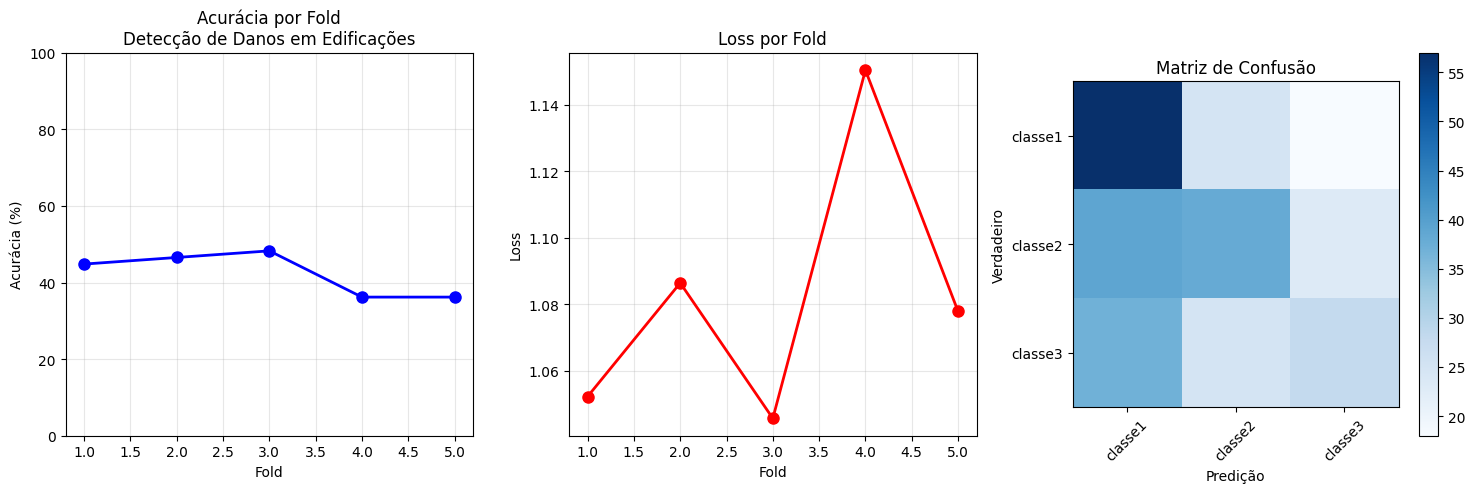

In [ ]:
print("\n" + "=" * 60)
print("RESULTADOS DA VALIDAÇÃO CRUZADA - DETECÇÃO DE DANOS")
print("=" * 60)

for fold in range(k_folds):
    print(f'Fold {fold + 1}: Accuracy = {fold_accuracies[fold]:.2f}%, Loss = {fold_losses[fold]:.4f}')

print(f'\nEstatísticas Finais:')
print(f'Acurácia Média: {np.mean(fold_accuracies):.2f}% (+/- {np.std(fold_accuracies):.2f}%)')
print(f'Loss Médio: {np.mean(fold_losses):.4f}')

# Matriz de confusão
cm = confusion_matrix(all_targets, all_predictions)
print(f'\nMatriz de Confusão:')
print(cm)

# BEM PLOTLIB, VEMMMM
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, k_folds + 1), fold_accuracies, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Fold')
plt.ylabel('Acurácia (%)')
plt.title('Acurácia por Fold\nDetecção de Danos em Edificações')
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)

plt.subplot(1, 3, 2)
plt.plot(range(1, k_folds + 1), fold_losses, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('Loss por Fold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')

plt.tight_layout()
plt.show()


## 7. Treinamento do Modelo Final e Exportação

Treina o modelo final usando todo o dataset e salva os pesos treinados em .pth que é o mesmo loop de treinamento final do script

Visualizando exemplos de classificações do modelo:


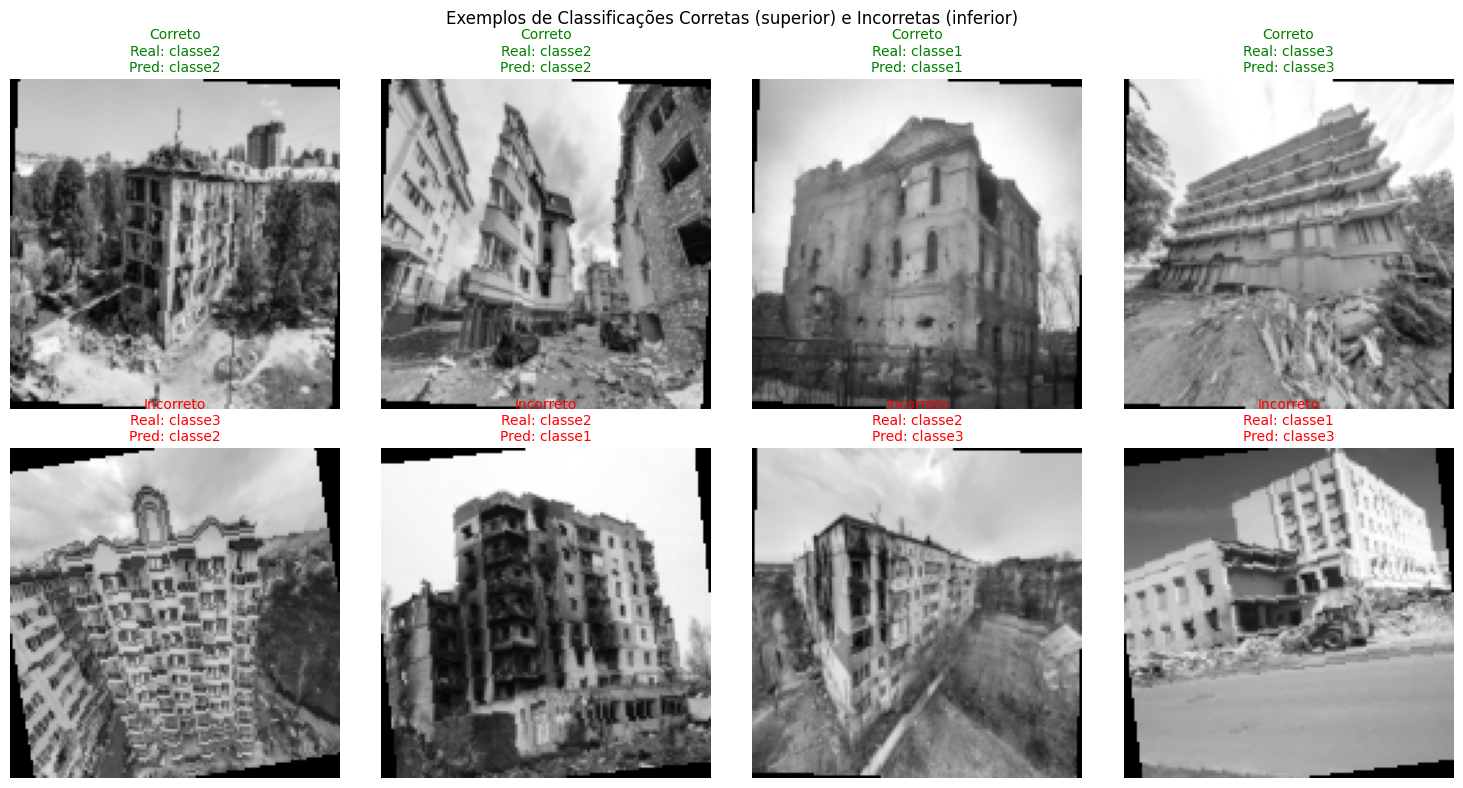

In [ ]:

def show_predictions(model, dataloader, num_images=8):
    model.eval()
    all_images = []
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            # Converter tensores para numpy
            images = images.cpu().numpy()
            labels = labels.cpu().numpy()
            predicted = predicted.cpu().numpy()
            
            all_images.extend(images)
            all_labels.extend(labels)
            all_preds.extend(predicted)
            
            if len(all_images) >= num_images * 2:  # Coleta mais imagens que o necessário para ter variedade
                break
    
    # Separa as previsões corretas e incorretas
    correct_idx = [i for i in range(len(all_labels)) if all_labels[i] == all_preds[i]]
    incorrect_idx = [i for i in range(len(all_labels)) if all_labels[i] != all_preds[i]]
    
    # Random select entre corretas e incorrentas
    num_each = num_images // 2
    correct_samples = np.random.choice(correct_idx, min(num_each, len(correct_idx)), replace=False)
    incorrect_samples = np.random.choice(incorrect_idx, min(num_each, len(incorrect_idx)), replace=False)
    
    # gradezinha de visualização
    fig, axes = plt.subplots(2, num_each, figsize=(15, 8))
    
    # Mostra previsões corretas
    for i, idx in enumerate(correct_samples):
        img = all_images[idx][0]  # Remove canal único (grayscale)
        img = (img * 0.5) + 0.5  # Desnormaliza
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Correto\nReal: {classes[all_labels[idx]]}\nPred: {classes[all_preds[idx]]}',
                           color='green', fontsize=10)
    
    # Mostra previsões incorretas
    for i, idx in enumerate(incorrect_samples):
        img = all_images[idx][0]  # Remover canal único (grayscale)
        img = (img * 0.5) + 0.5  # Desnormalizar
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Incorreto\nReal: {classes[all_labels[idx]]}\nPred: {classes[all_preds[idx]]}',
                           color='red', fontsize=10)
    
    plt.suptitle('Exemplos de Classificações Corretas (superior) e Incorretas (inferior)', fontsize=12)
    plt.tight_layout()
    plt.show()

# Cria um DataLoader para visualização
viz_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Visualiza exemplos do último modelo treinado no fold
print("Visualizando exemplos de classificações do modelo:")
show_predictions(model, viz_loader, num_images=8)

# Considerações finais 

Baseando-se no googlecollab e forçando com gambiarra foi chegado a um ponto em que: A task da atividade foi atingida em 60%, a complexidade para implementação da proposta foi um pouquinho fora do escopo de minha capacidade.
a detecção de grayscale acaba identificando estruturas tombadas como "danificadas" e vice e versa.
o longo tempo de treino com o processador fez com que os resultados fossem abaixo de 50% de accuracy entre as classes.
foi buxa...